In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

#### Loading dataset

In [3]:
# Load the dataset
dataset_path = "/home/rionowcast/atmoseer/src/output_dataset_20_08.nc"

if not Path(dataset_path).exists():
    print(f"❌ Dataset not found at: {dataset_path}")
    print("Available output files:")
    for f in Path("/home/rionowcast/atmoseer/src/").glob("output*.nc"):
        print(f"  - {f}")
    # Exit if no file found
    ds = None
else:
    print(f"✅ Loading dataset from: {dataset_path}")
    ds = xr.open_dataset(dataset_path)
    print(f"Dataset loaded successfully!")
    print(f"X data shape: {ds['x'].shape}")
    print(f"Y data shape: {ds['y'].shape}")

✅ Loading dataset from: /home/rionowcast/atmoseer/src/output_dataset_20_08.nc


/home/rionowcast/.conda/envs/atmoseer/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


Dataset loaded successfully!
X data shape: (22741, 5, 21, 27, 9)
Y data shape: (22741, 5, 21, 27, 9)


In [4]:
# Inspect dataset metadata
if ds is not None:
    print("=== Dataset Overview ===")
    print(f"Dimensions: {dict(ds.dims)}")
    print(f"Coordinates: {list(ds.coords.keys())}")
    print(f"Variables: {list(ds.data_vars.keys())}")
    print(f"Attributes: {list(ds.attrs.keys())}")
    
    print("\n=== Feature Names ===")
    if 'channel' in ds.coords:
        feature_names = ds.channel.values
        print(f"Available channels/features: {feature_names}")
    else:
        print("No 'channel' coordinate found")
    
    if 'feature_names' in ds.attrs:
        print(f"Feature names from attributes: {ds.attrs['feature_names']}")
    
    print("\n=== Sample Timestamps ===")
    if 'sample_timestamps' in ds.coords:
        print(f"Sample timestamps shape: {ds.sample_timestamps.shape}")
        print(f"First sample timestamps: {ds.sample_timestamps.isel(sample=0).values}")
    else:
        print("No 'sample_timestamps' coordinate found")
    
    print("\n=== Data Variables Info ===")
    for var in ds.data_vars:
        print(f"{var}: {ds[var].dims} -> {ds[var].shape}")
else:
    print("❌ Dataset not loaded")

=== Dataset Overview ===
Dimensions: {'sample': 22741, 'time': 5, 'lat': 21, 'lon': 27, 'channel': 9}
Coordinates: ['sample', 'time', 'lat', 'lon', 'channel', 'sample_x_timestamps', 'sample_y_timestamps']
Variables: ['x', 'y']
Attributes: ['description', 'feature_channels', 'timestep', 'max_gap_minutes', 'total_samples', 'creation_date']

=== Feature Names ===
Available channels/features: ['densidade_flashes' 'glaciacao_topo_nuvem' 'gradiente_vapor_agua'
 'li_proxy' 'movimento_vertical' 'profundidade_nuvens'
 'tamanho_particulas' 'temperatura_topo_nuvem'
 'textura_local_profundidade']

=== Sample Timestamps ===
No 'sample_timestamps' coordinate found

=== Data Variables Info ===
x: ('sample', 'time', 'lat', 'lon', 'channel') -> (22741, 5, 21, 27, 9)
y: ('sample', 'time', 'lat', 'lon', 'channel') -> (22741, 5, 21, 27, 9)


/home/rionowcast/.conda/envs/atmoseer/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [5]:
# Sanity checks for features (x) and target (y) before training
if ds is not None and 'x' in ds and 'y' in ds:
    print('=== Sanity checks for features (x) and target (y) ===')
    x = ds['x'].values
    y = ds['y'].values
    
    # Features: check for NaN and inf
    x_nan = np.isnan(x).sum()
    x_inf = np.isinf(x).sum()
    print(f"Features (x): NaN count = {x_nan}, Inf count = {x_inf}")
    if x_nan > 0 or x_inf > 0:
        print("⚠️ Atenção: Existem valores NaN ou Inf nas features!")
    else:
        print("✅ Features (x) sem NaN ou Inf.")
    
    # Target: check for NaN, inf, and negatives
    y_nan = np.isnan(y).sum()
    y_inf = np.isinf(y).sum()
    y_neg = (y < 0).sum()
    print(f"Target (y): NaN count = {y_nan}, Inf count = {y_inf}, Negativos = {y_neg}")
    if y_nan > 0 or y_inf > 0 or y_neg > 0:
        print("⚠️ Atenção: Existem valores NaN, Inf ou negativos no target!")
    else:
        print("✅ Target (y) sem NaN, Inf ou negativos.")
else:
    print("❌ Dataset não carregado ou variáveis 'x'/'y' ausentes.")

=== Sanity checks for features (x) and target (y) ===
Features (x): NaN count = 0, Inf count = 0
✅ Features (x) sem NaN ou Inf.
Target (y): NaN count = 0, Inf count = 0, Negativos = 0
✅ Target (y) sem NaN, Inf ou negativos.


In [6]:
# Calcular frequência das faixas de precipitação e sugerir pesos para loss ponderada (forçando mínimo antes de normalizar)
if ds is not None and 'y' in ds:
    y = ds['y'].values  # (sample, time, lat, lon, channel)
    # Considerar apenas o canal 0 (precipitação)
    y_precip = y[..., 0]
    # Voltar para escala original se estiver em log1p
    if np.nanmax(y_precip) < 20:
        y_precip = np.expm1(y_precip)
    # Flatten para 1D
    y_flat = y_precip.flatten()
    # Definir faixas
    bins = [0, 5, 25, 50, np.inf]
    labels = ['0-5', '5-25', '25-50', '50-inf']
    y_cats = np.digitize(y_flat, bins, right=False) - 1  # 0,1,2,3
    # Frequência absoluta e relativa
    counts = np.bincount(y_cats, minlength=4)
    total = counts.sum()
    freqs = counts / total
    print('Frequência absoluta por faixa:', dict(zip(labels, counts)))
    print('Frequência relativa por faixa:', dict(zip(labels, [f"{f:.8f}" for f in freqs])))
    # Pesos inversamente proporcionais à frequência
    weights = 1.0 / (freqs + 1e-8)
    # Forçar mínimo antes de normalizar
    min_weight = 0.1  # Valor mínimo mais significativo
    weights = np.maximum(weights, min_weight)
    weights = weights / weights.sum()  # Normalizar para somar 1
    print('Pesos sugeridos para loss ponderada:', dict(zip(labels, [f"{w:.8f}" for w in weights])))
else:
    print('❌ Dataset não carregado ou variável y ausente.')

Frequência absoluta por faixa: {'0-5': 63005857, '5-25': 1425918, '25-50': 36589, '50-inf': 2371}
Frequência relativa por faixa: {'0-5': '0.97727840', '5-25': '0.02211729', '25-50': '0.00056753', '50-inf': '0.00003678'}
Pesos sugeridos para loss ponderada: {'0-5': '0.00003529', '5-25': '0.00155950', '25-50': '0.06077474', '50-inf': '0.93763046'}


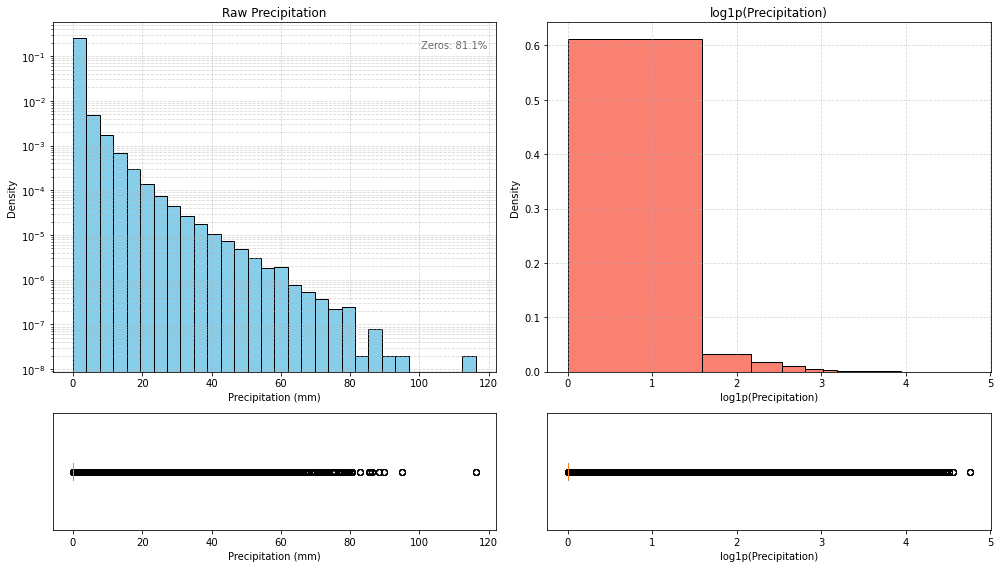

In [7]:
# Improved: Compare precipitation data before and after log1p using histograms and boxplots

if ds is not None and 'y' in ds:
    y = ds['y'].values  # (sample, time, lat, lon, channel)
    y_precip = y[..., 0].flatten()
    y_log = np.log1p(y_precip)

    # Calculate percentage of zeros
    pct_zeros = (y_precip == 0).sum() / y_precip.size * 100

    # Use the same bins for both histograms
    bins = np.histogram_bin_edges(y_precip, bins=30)
    log_bins = np.log1p(bins)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Raw histogram
    axes[0, 0].hist(y_precip, bins=bins, color='skyblue', edgecolor='k', density=True)
    axes[0, 0].set_title('Raw Precipitation')
    axes[0, 0].set_xlabel('Precipitation (mm)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, which='both', linestyle='--', alpha=0.5)
    axes[0, 0].text(0.98, 0.95, f'Zeros: {pct_zeros:.1f}%', ha='right', va='top', transform=axes[0, 0].transAxes, fontsize=10, color='dimgray')

    # log1p histogram
    axes[0, 1].hist(y_log, bins=log_bins, color='salmon', edgecolor='k', density=True)
    axes[0, 1].set_title('log1p(Precipitation)')
    axes[0, 1].set_xlabel('log1p(Precipitation)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].grid(True, which='both', linestyle='--', alpha=0.5)

    # Raw boxplot
    axes[1, 0].boxplot(y_precip, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    axes[1, 0].set_xlabel('Precipitation (mm)')
    axes[1, 0].set_yticks([])

    # log1p boxplot
    axes[1, 1].boxplot(y_log, vert=False, patch_artist=True, boxprops=dict(facecolor='salmon'))
    axes[1, 1].set_xlabel('log1p(Precipitation)')
    axes[1, 1].set_yticks([])

    plt.tight_layout()
    plt.show()
else:
    print('❌ Dataset not loaded or variable y not found.')

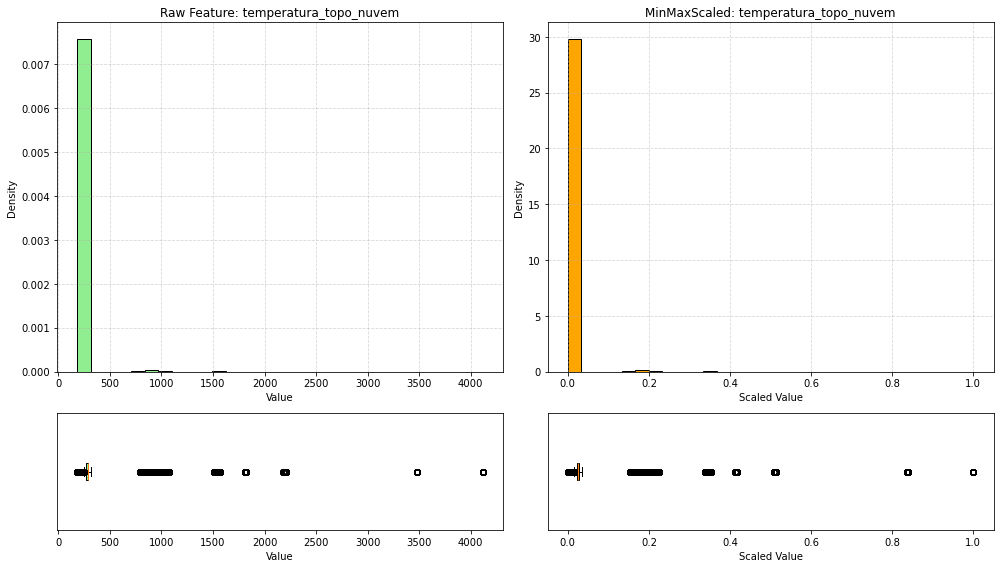

In [8]:
# Compare a selected feature before and after MinMaxScaler transformation
from sklearn.preprocessing import MinMaxScaler

if ds is not None and 'x' in ds:
    # Select feature/channel index (edit as needed)
    feature_idx = 7  # Change to select a different feature
    feature_name = ds.channel.values[feature_idx] if 'channel' in ds.coords else f'Ch_{feature_idx}'
    x = ds['x'].values  # (sample, time, lat, lon, channel)
    x_feat = x[..., feature_idx].flatten()
    x_feat = x_feat[~np.isnan(x_feat)]  # Remove NaNs for scaling

    # Fit MinMaxScaler
    scaler = MinMaxScaler()
    x_feat_scaled = scaler.fit_transform(x_feat.reshape(-1, 1)).flatten()

    # Plot histograms and boxplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Raw histogram
    axes[0, 0].hist(x_feat, bins=30, color='lightgreen', edgecolor='k', density=True)
    axes[0, 0].set_title(f'Raw Feature: {feature_name}')
    axes[0, 0].set_xlabel('Value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].grid(True, linestyle='--', alpha=0.5)

    # Scaled histogram
    axes[0, 1].hist(x_feat_scaled, bins=30, color='orange', edgecolor='k', density=True)
    axes[0, 1].set_title(f'MinMaxScaled: {feature_name}')
    axes[0, 1].set_xlabel('Scaled Value')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].grid(True, linestyle='--', alpha=0.5)

    # Raw boxplot
    axes[1, 0].boxplot(x_feat, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    axes[1, 0].set_xlabel('Value')
    axes[1, 0].set_yticks([])

    # Scaled boxplot
    axes[1, 1].boxplot(x_feat_scaled, vert=False, patch_artist=True, boxprops=dict(facecolor='orange'))
    axes[1, 1].set_xlabel('Scaled Value')
    axes[1, 1].set_yticks([])

    plt.tight_layout()
    plt.show()
else:
    print('❌ Dataset not loaded or variable x not found.')

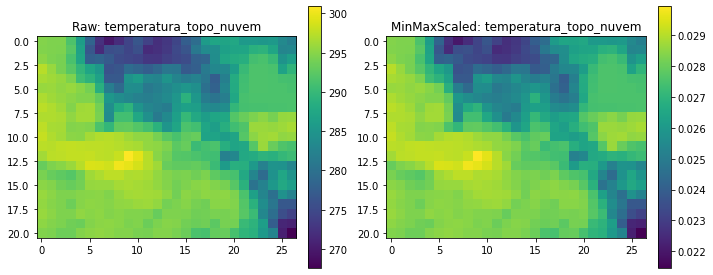

In [9]:
# Compare a selected feature at a single timestep before and after MinMaxScaler transformation
from sklearn.preprocessing import MinMaxScaler

if ds is not None and 'x' in ds:
    # Select feature/channel and timestep (edit as needed)
    feature_idx = 7  # Change to select a different feature
    timestep_idx = 0  # Change to select a different timestep
    feature_name = ds.channel.values[feature_idx] if 'channel' in ds.coords else f'Ch_{feature_idx}'
    x = ds['x'].values  # (sample, time, lat, lon, channel)
    # Use first sample for demonstration
    x_sample = x[0, timestep_idx, ..., feature_idx]  # (lat, lon)
    # Flatten all values of this feature for scaling
    x_feat_all = x[..., feature_idx].flatten()
    x_feat_all = x_feat_all[~np.isnan(x_feat_all)]
    scaler = MinMaxScaler()
    scaler.fit(x_feat_all.reshape(-1, 1))
    # Scale the selected timestep
    x_sample_scaled = scaler.transform(x_sample.reshape(-1, 1)).reshape(x_sample.shape)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axes[0].imshow(x_sample, cmap='viridis', aspect='equal')
    axes[0].set_title(f'Raw: {feature_name}')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    im1 = axes[1].imshow(x_sample_scaled, cmap='viridis', aspect='equal')
    axes[1].set_title(f'MinMaxScaled: {feature_name}')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print('❌ Dataset not loaded or variable x not found.')

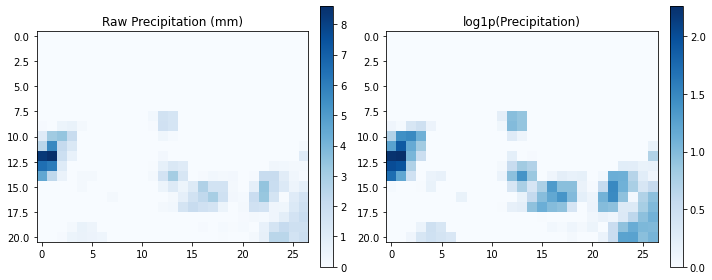

In [10]:
# Compare the target (precipitation) at a single timestep before and after log1p transformation
if ds is not None and 'y' in ds:
    # Select timestep and sample (edit as needed)
    sample_idx = 0  # Change to select a different sample
    timestep_idx = 0  # Change to select a different timestep
    
    y = ds['y'].values  # (sample, time, lat, lon, channel)
    # Use channel 0 for precipitation
    y_sample = y[sample_idx, timestep_idx, ..., 0]  # (lat, lon)
    
    # log1p transform (safe for zeros)
    y_sample_log1p = np.log1p(y_sample)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axes[0].imshow(y_sample, cmap='Blues', aspect='equal')
    axes[0].set_title('Raw Precipitation (mm)')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    im1 = axes[1].imshow(y_sample_log1p, cmap='Blues', aspect='equal')
    axes[1].set_title('log1p(Precipitation)')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print('❌ Dataset not loaded or variable y not found.')

#### Plot from sample 0 in the x data variable (all channels)

Sample 0 shape: (5, 21, 27, 9)
Number of timesteps: 5
Total channels available: 9
Channels to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Feature names: ['densidade_flashes' 'glaciacao_topo_nuvem' 'gradiente_vapor_agua'
 'li_proxy' 'movimento_vertical' 'profundidade_nuvens'
 'tamanho_particulas' 'temperatura_topo_nuvem'
 'textura_local_profundidade']
Sample X timestamps: ['2019-02-19T15:00:00.000000000' '2019-02-19T16:00:00.000000000'
 '2019-02-19T17:00:00.000000000' '2019-02-19T18:00:00.000000000'
 '2019-02-19T19:00:00.000000000']


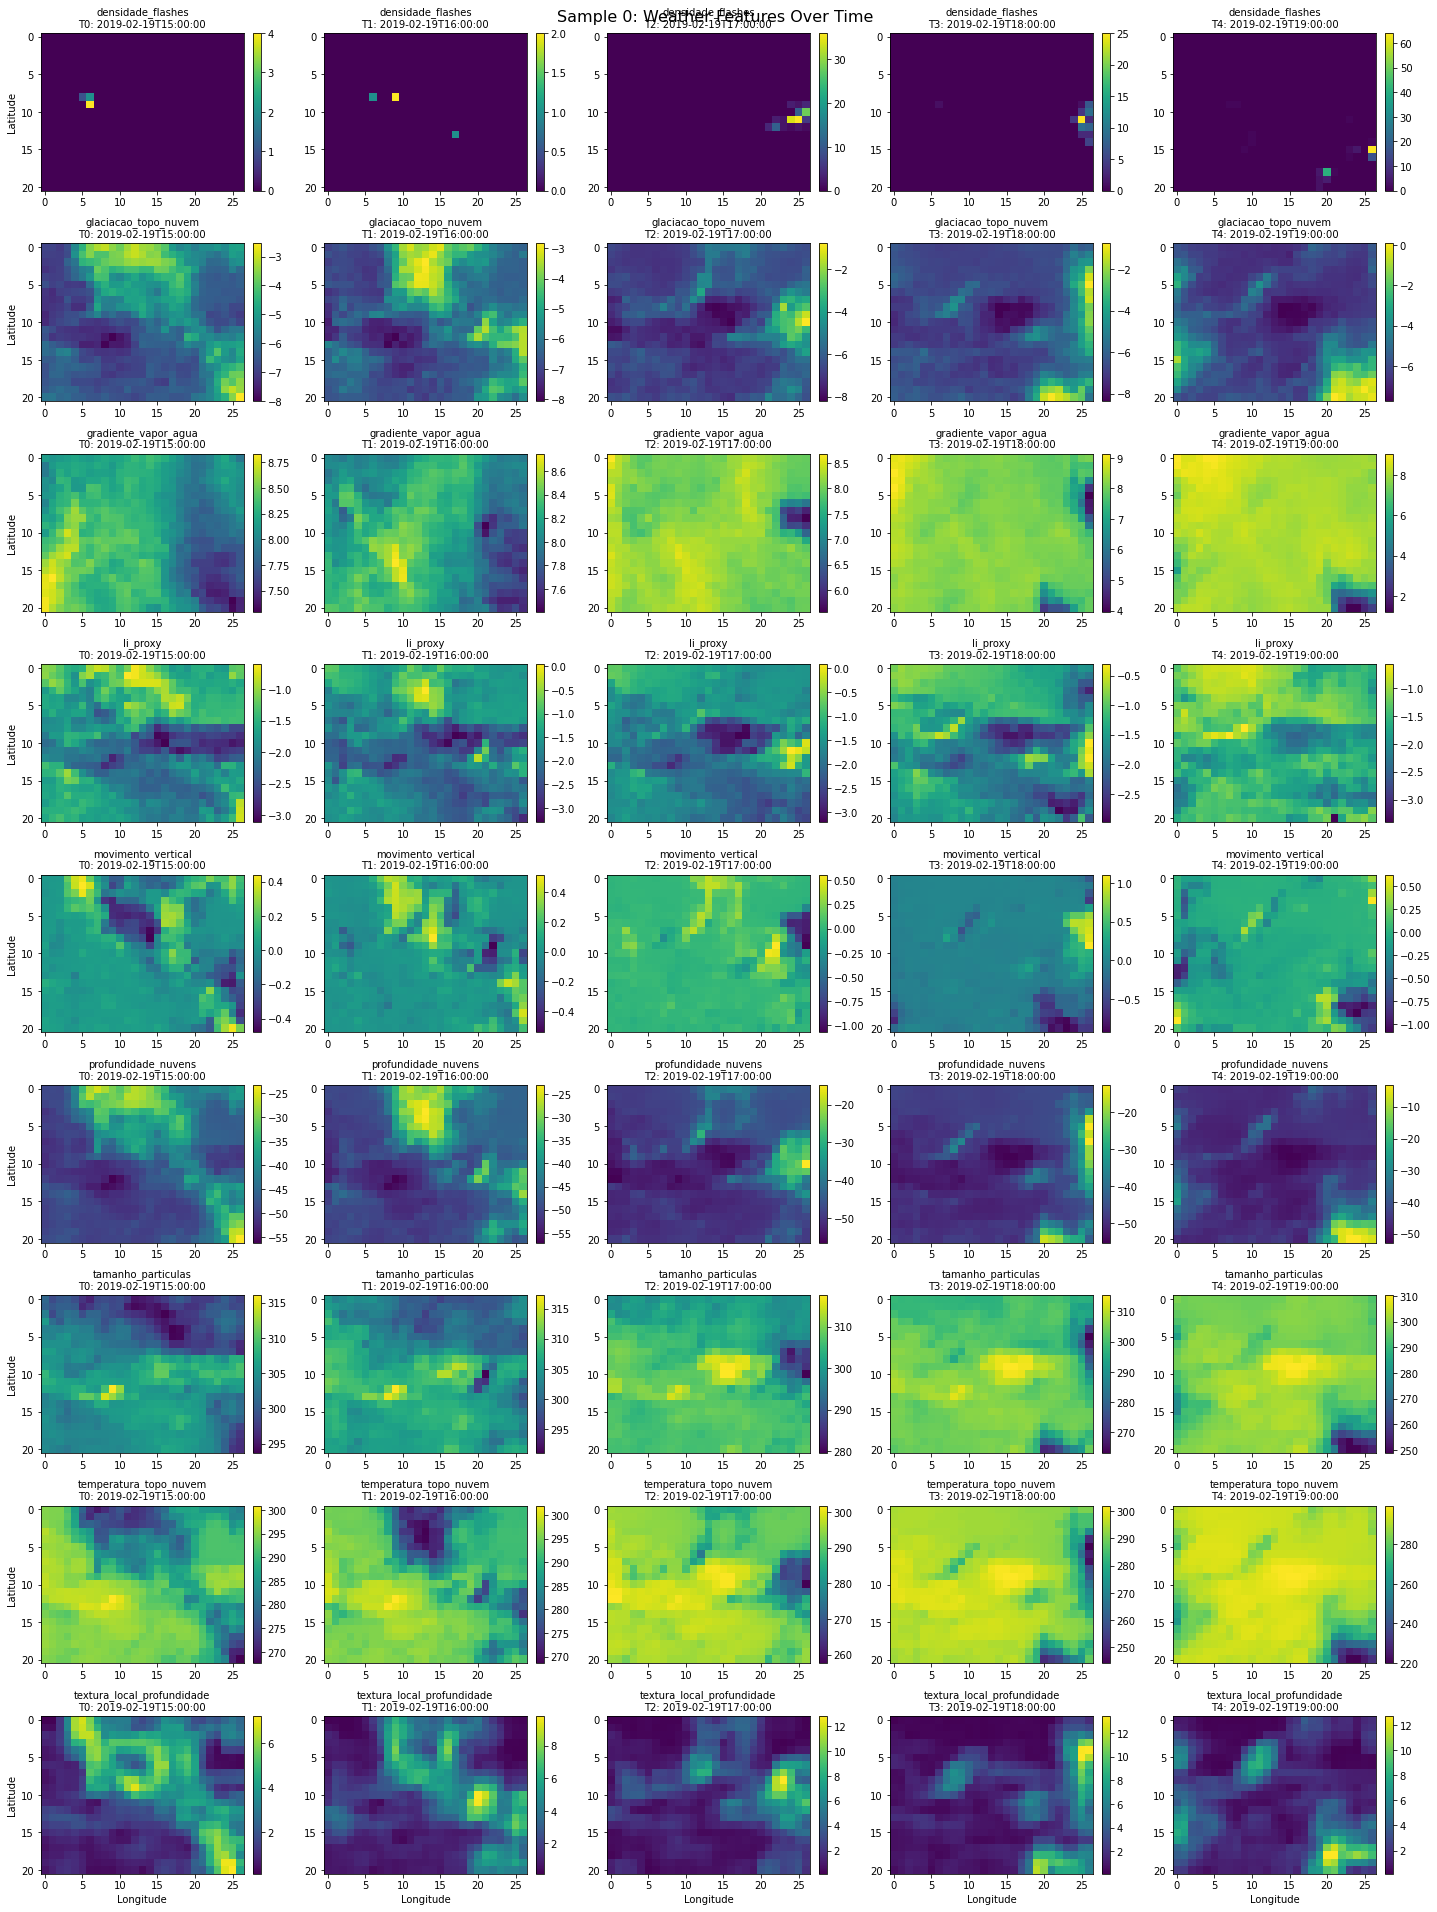

In [11]:
# Plot selected channels and timestamps from a chosen sample in the x data variable
if ds is not None and 'x' in ds:
    # Configuration - Edit these parameters to customize the plot
    sample_idx = 0  # Choose which sample to visualize (0, 1, 2, ...)
    channels_to_plot = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Choose which channels to display (e.g., [0, 2, 4] for channels 0, 2, and 4)
    
    # Extract the chosen sample from x data
    sample_data = ds['x'].isel(sample=sample_idx)  # Shape: (time, lat, lon, channel)
    n_timesteps = sample_data.shape[0]
    total_channels = sample_data.shape[-1]
    
    # Get feature names and timestamps
    feature_names = ds.channel.values if 'channel' in ds.coords else [f"Ch_{i}" for i in range(total_channels)]
    sample_timestamps = ds.sample_x_timestamps.isel(sample=sample_idx).values if 'sample_x_timestamps' in ds.coords else None
    
    # Validate channel selection
    channels_to_plot = [ch for ch in channels_to_plot if 0 <= ch < total_channels]
    n_channels_to_plot = len(channels_to_plot)
    
    if n_channels_to_plot == 0:
        print(f"❌ No valid channels selected. Available channels: 0 to {total_channels-1}")
    else:
        print(f"Sample {sample_idx} shape: {sample_data.shape}")
        print(f"Number of timesteps: {n_timesteps}")
        print(f"Total channels available: {total_channels}")
        print(f"Channels to plot: {channels_to_plot}")
        print(f"Feature names: {feature_names}")
        if sample_timestamps is not None:
            print(f"Sample X timestamps: {sample_timestamps}")
        
        # Create a grid plot: selected channels as rows, timesteps as columns
        fig, axes = plt.subplots(n_channels_to_plot, n_timesteps, figsize=(4 * n_timesteps, 3 * n_channels_to_plot))
        
        # Handle single channel or single timestep cases
        if n_channels_to_plot == 1 and n_timesteps == 1:
            axes = np.array([[axes]])
        elif n_channels_to_plot == 1:
            axes = axes.reshape(1, -1)
        elif n_timesteps == 1:
            axes = axes.reshape(-1, 1)
        
        # Plot each selected channel and timestep
        for row_idx, ch in enumerate(channels_to_plot):
            feature_name = feature_names[ch] if ch < len(feature_names) else f"Ch_{ch}"
            
            for t in range(n_timesteps):
                # Get data for timestep t, channel ch
                data_t = sample_data.isel(time=t, channel=ch).values
                
                # Create title with feature name and timestamp
                if sample_timestamps is not None:
                    timestamp_str = str(sample_timestamps[t])[:19]  # Format timestamp
                    title = f'{feature_name}\nT{t}: {timestamp_str}'
                else:
                    title = f'{feature_name}\nTimestep {t}'
                
                # Plot the spatial data
                im = axes[row_idx, t].imshow(data_t, cmap='viridis', aspect='equal')
                axes[row_idx, t].set_title(title, fontsize=10)
                axes[row_idx, t].grid(False)  # Remove grid
                
                # Add labels only on edges
                if t == 0:
                    axes[row_idx, t].set_ylabel(f'Latitude')
                if row_idx == n_channels_to_plot - 1:
                    axes[row_idx, t].set_xlabel('Longitude')
                
                # Add colorbar
                plt.colorbar(im, ax=axes[row_idx, t], fraction=0.046, pad=0.04)
        
        plt.suptitle(f'Sample {sample_idx}: Weather Features Over Time', fontsize=16)
        plt.tight_layout()
        plt.show()
    
else:
    print("❌ Dataset not loaded or 'x' variable not found")

Sample 0 shape: (5, 21, 27, 9)
Number of timesteps: 5
Total channels available: 9
Channels to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Channel names: ['densidade_flashes' 'glaciacao_topo_nuvem' 'gradiente_vapor_agua'
 'li_proxy' 'movimento_vertical' 'profundidade_nuvens'
 'tamanho_particulas' 'temperatura_topo_nuvem'
 'textura_local_profundidade']
Sample Y timestamps: ['2019-02-19T20:00:00.000000000' '2019-02-19T21:00:00.000000000'
 '2019-02-19T22:00:00.000000000' '2019-02-19T23:00:00.000000000'
 '2019-02-20T00:00:00.000000000']


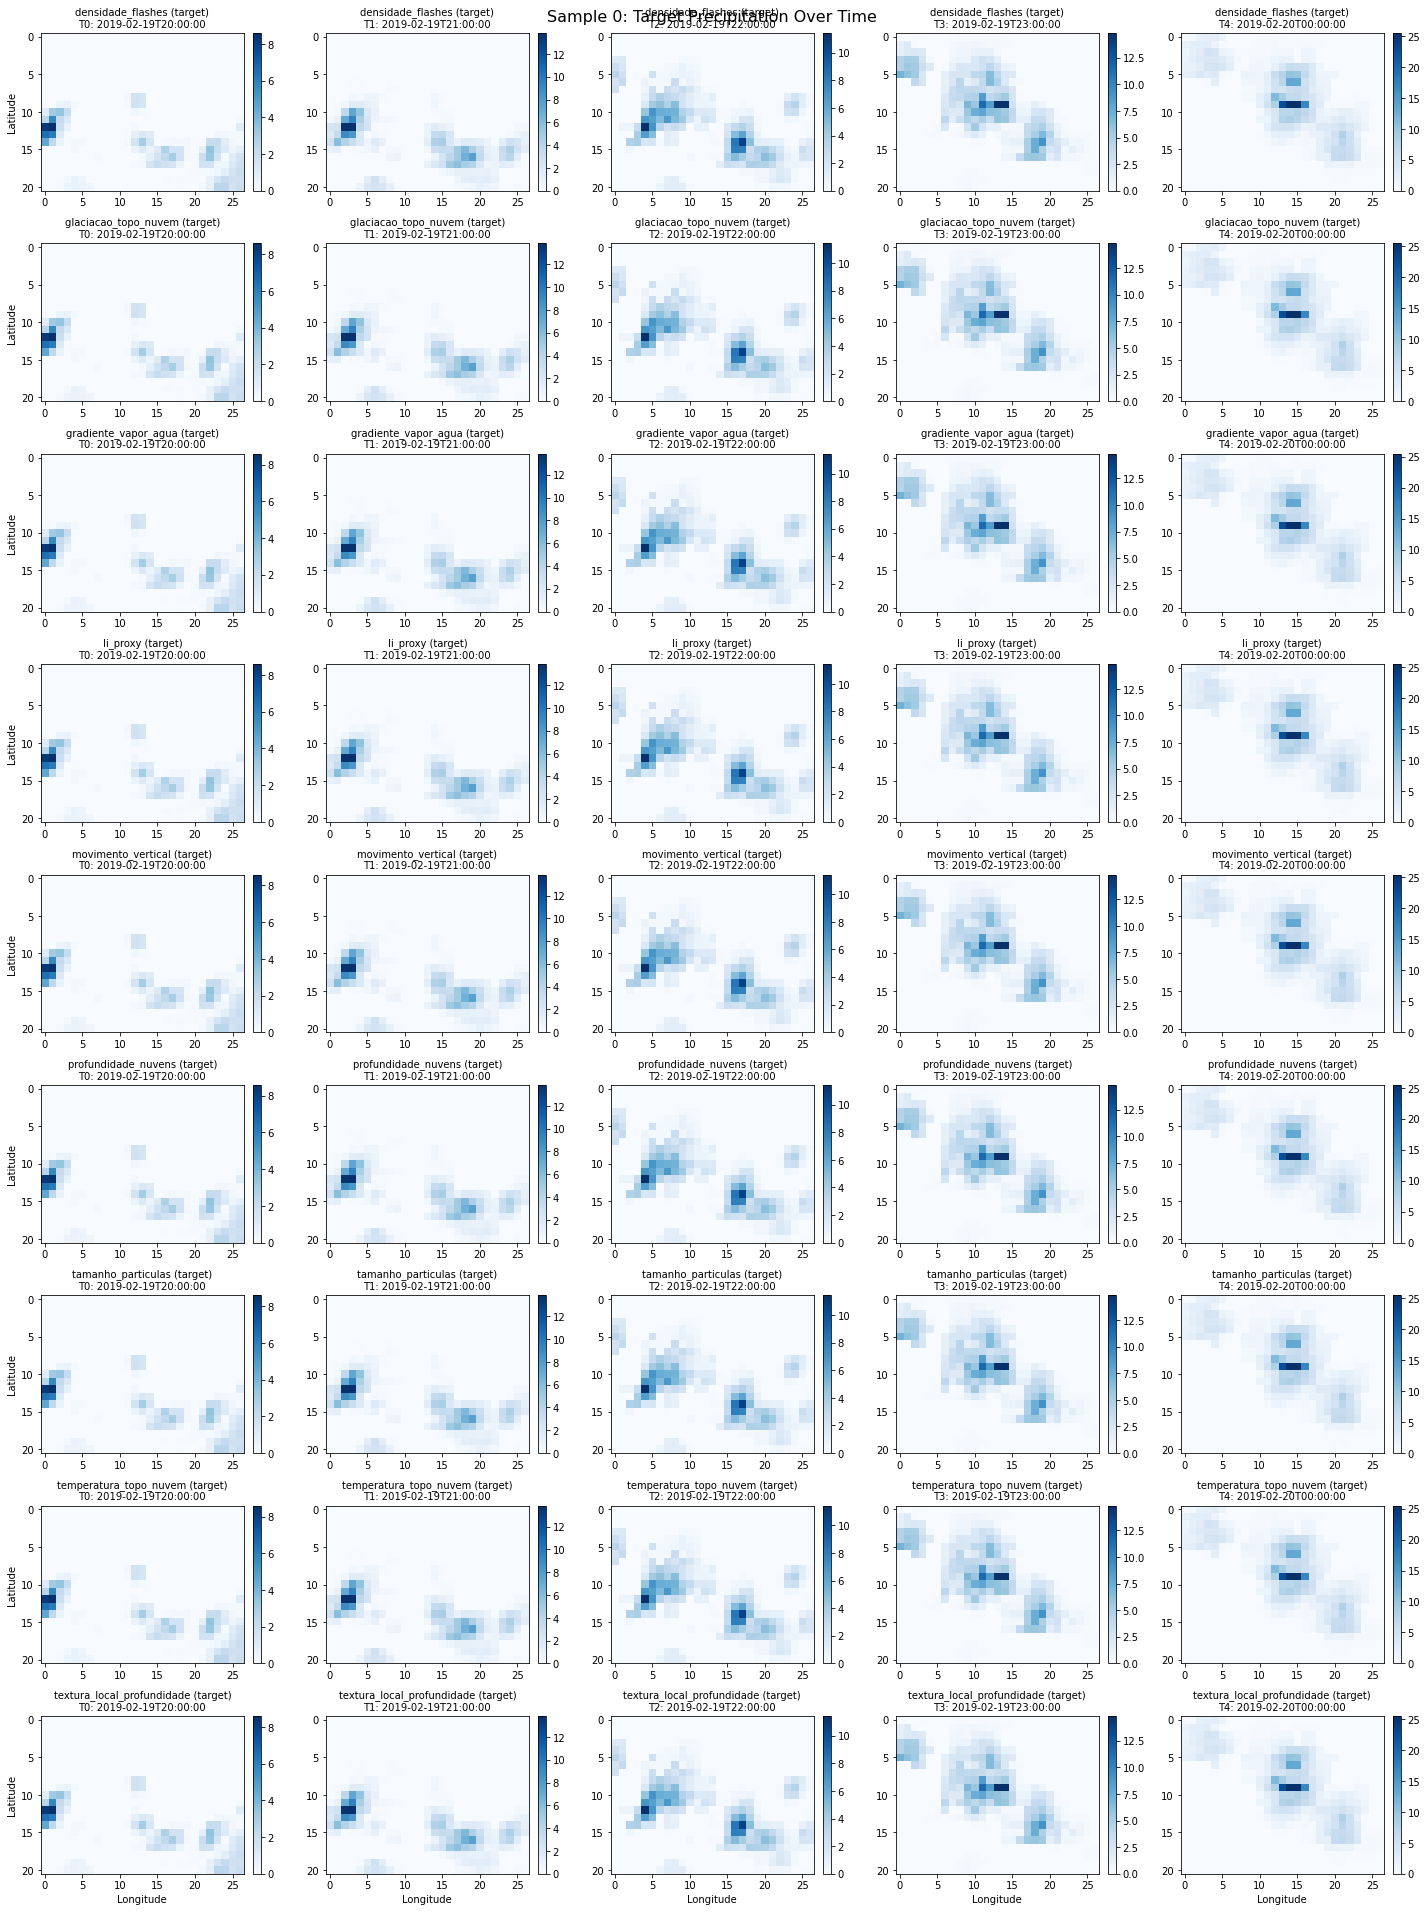

In [12]:
# Plot selected channels and timestamps from a chosen sample in the y data variable (target/precipitation)
if ds is not None and 'y' in ds:
    # Configuration - Edit these parameters to customize the plot
    sample_idx = 0  # Choose which sample to visualize (0, 1, 2, ...)
    channels_to_plot = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # For y, usually only 1 channel (precipitation), but keep as list for generality
    
    # Extract the chosen sample from y data
    sample_data = ds['y'].isel(sample=sample_idx)  # Shape: (time, lat, lon, channel)
    n_timesteps = sample_data.shape[0]
    total_channels = sample_data.shape[-1]
    
    # Get channel names and timestamps
    channel_names = ds.channel.values if 'channel' in ds.coords else [f"Ch_{i}" for i in range(total_channels)]
    sample_timestamps = ds.sample_y_timestamps.isel(sample=sample_idx).values if 'sample_y_timestamps' in ds.coords else None
    
    # Validate channel selection
    channels_to_plot = [ch for ch in channels_to_plot if 0 <= ch < total_channels]
    n_channels_to_plot = len(channels_to_plot)
    
    if n_channels_to_plot == 0:
        print(f"❌ No valid channels selected. Available channels: 0 to {total_channels-1}")
    else:
        print(f"Sample {sample_idx} shape: {sample_data.shape}")
        print(f"Number of timesteps: {n_timesteps}")
        print(f"Total channels available: {total_channels}")
        print(f"Channels to plot: {channels_to_plot}")
        print(f"Channel names: {channel_names}")
        if sample_timestamps is not None:
            print(f"Sample Y timestamps: {sample_timestamps}")
        
        # Create a grid plot: selected channels as rows, timesteps as columns
        fig, axes = plt.subplots(n_channels_to_plot, n_timesteps, figsize=(4 * n_timesteps, 3 * n_channels_to_plot))
        
        # Handle single channel or single timestep cases
        if n_channels_to_plot == 1 and n_timesteps == 1:
            axes = np.array([[axes]])
        elif n_channels_to_plot == 1:
            axes = axes.reshape(1, -1)
        elif n_timesteps == 1:
            axes = axes.reshape(-1, 1)
        
        # Plot each selected channel and timestep
        for row_idx, ch in enumerate(channels_to_plot):
            channel_name = channel_names[ch] if ch < len(channel_names) else f"Ch_{ch}"
            
            for t in range(n_timesteps):
                # Get data for timestep t, channel ch
                data_t = sample_data.isel(time=t, channel=ch).values
                
                # Create title with channel name and timestamp
                if sample_timestamps is not None:
                    timestamp_str = str(sample_timestamps[t])[:19]  # Format timestamp
                    title = f'{channel_name} (target)\nT{t}: {timestamp_str}'
                else:
                    title = f'{channel_name} (target)\nTimestep {t}'
                
                # Plot the spatial data
                im = axes[row_idx, t].imshow(data_t, cmap='Blues', aspect='equal')
                axes[row_idx, t].set_title(title, fontsize=10)
                axes[row_idx, t].grid(False)  # Remove grid
                
                # Add labels only on edges
                if t == 0:
                    axes[row_idx, t].set_ylabel(f'Latitude')
                if row_idx == n_channels_to_plot - 1:
                    axes[row_idx, t].set_xlabel('Longitude')
                
                # Add colorbar
                plt.colorbar(im, ax=axes[row_idx, t], fraction=0.046, pad=0.04)
        
        plt.suptitle(f'Sample {sample_idx}: Target Precipitation Over Time', fontsize=16)
        plt.tight_layout()
        plt.show()
    
else:
    print("❌ Dataset not loaded or 'y' variable not found")

In [13]:
# Display feature names and timestamps for selected sample
if ds is not None:
    sample_to_inspect = 0  # Change this to inspect different samples
    
    print(f"=== Sample {sample_to_inspect} Metadata ===")
    
    # Feature names
    if 'channel' in ds.coords:
        feature_names = ds.channel.values
        print(f"Feature names ({len(feature_names)} channels):")
        for i, name in enumerate(feature_names):
            print(f"  Channel {i}: {name}")
    
    # Timestamps for this sample (X and Y)
    if 'sample_x_timestamps' in ds.coords:
        x_timestamps = ds.sample_x_timestamps.isel(sample=sample_to_inspect).values
        print(f"\nX timestamps for sample {sample_to_inspect}:")
        for i, ts in enumerate(x_timestamps):
            print(f"  X Timestep {i}: {ts}")
    if 'sample_y_timestamps' in ds.coords:
        y_timestamps = ds.sample_y_timestamps.isel(sample=sample_to_inspect).values
        print(f"\nY timestamps for sample {sample_to_inspect}:")
        for i, ts in enumerate(y_timestamps):
            print(f"  Y Timestep {i}: {ts}")
    
    print(f"\nData shape: {ds['x'].isel(sample=sample_to_inspect).shape}")
    print("(time, lat, lon, channel)")
else:
    print("❌ Dataset not loaded")

=== Sample 0 Metadata ===
Feature names (9 channels):
  Channel 0: densidade_flashes
  Channel 1: glaciacao_topo_nuvem
  Channel 2: gradiente_vapor_agua
  Channel 3: li_proxy
  Channel 4: movimento_vertical
  Channel 5: profundidade_nuvens
  Channel 6: tamanho_particulas
  Channel 7: temperatura_topo_nuvem
  Channel 8: textura_local_profundidade

X timestamps for sample 0:
  X Timestep 0: 2019-02-19T15:00:00.000000000
  X Timestep 1: 2019-02-19T16:00:00.000000000
  X Timestep 2: 2019-02-19T17:00:00.000000000
  X Timestep 3: 2019-02-19T18:00:00.000000000
  X Timestep 4: 2019-02-19T19:00:00.000000000

Y timestamps for sample 0:
  Y Timestep 0: 2019-02-19T20:00:00.000000000
  Y Timestep 1: 2019-02-19T21:00:00.000000000
  Y Timestep 2: 2019-02-19T22:00:00.000000000
  Y Timestep 3: 2019-02-19T23:00:00.000000000
  Y Timestep 4: 2019-02-20T00:00:00.000000000

Data shape: (5, 21, 27, 9)
(time, lat, lon, channel)


Found 1078 (sample, time) steps with at least one pixel > 50mm.


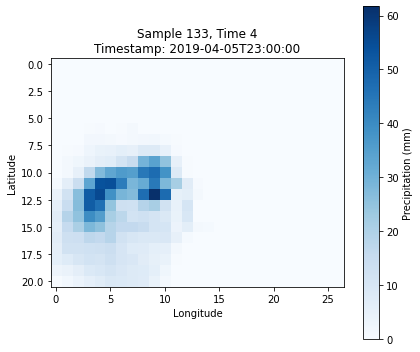

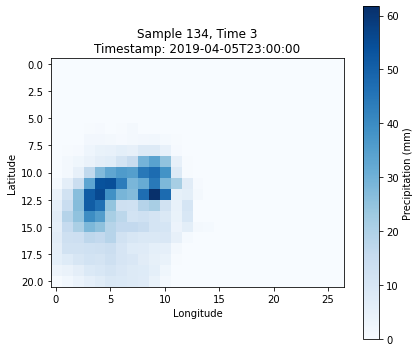

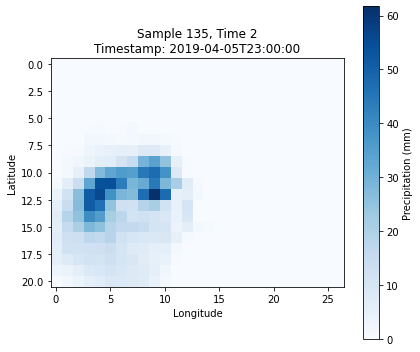

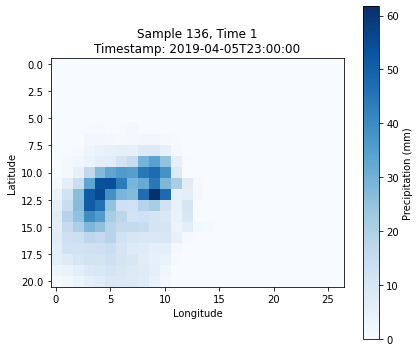

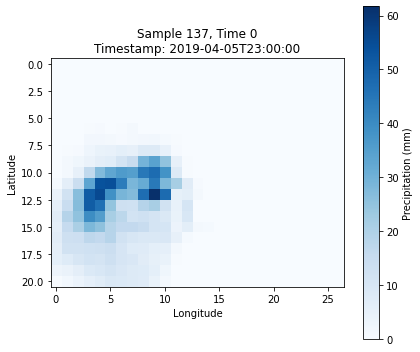

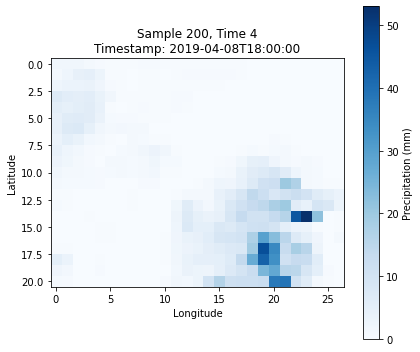

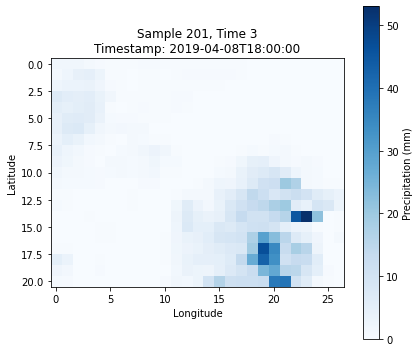

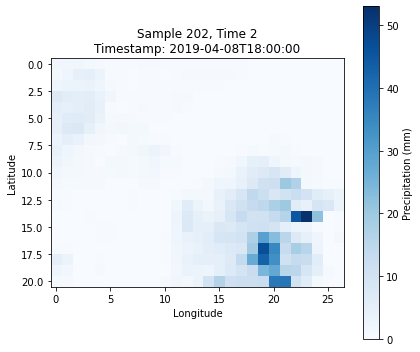

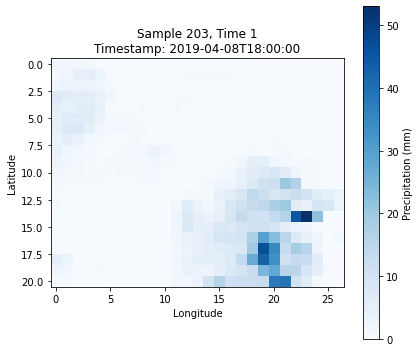

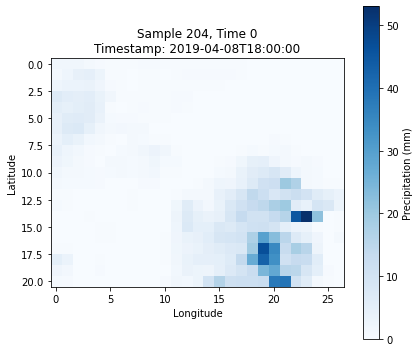

Showing only first 10 extreme events.


In [14]:
# Plot the target precipitation fields for timesteps with any pixel > 50mm
if ds is not None and 'y' in ds:
    y = ds['y'].values  # (sample, time, lat, lon, channel)
    y_precip = y[..., 0]
    # Convert back to original scale if in log1p
    if np.nanmax(y_precip) < 20:
        y_precip = np.expm1(y_precip)
    n_samples, n_times, n_lat, n_lon = y_precip.shape[:4]
    
    # Find (sample, time) indices where any pixel > 50mm
    extreme_mask = (y_precip > 50).reshape(n_samples, n_times, -1).any(axis=2)
    extreme_indices = np.argwhere(extreme_mask)
    
    print(f"Found {len(extreme_indices)} (sample, time) steps with at least one pixel > 50mm.")
    
    # For each (sample, time) with extreme event, plot the precipitation field
    import matplotlib.pyplot as plt
    for idx, (sample_idx, time_idx) in enumerate(extreme_indices):
        plt.figure(figsize=(6, 5))
        data = y_precip[sample_idx, time_idx]
        plt.imshow(data, cmap='Blues', aspect='equal')
        plt.colorbar(label='Precipitation (mm)')
        title = f"Sample {sample_idx}, Time {time_idx}"
        # Add timestamp if available
        if 'sample_y_timestamps' in ds.coords:
            ts = ds['sample_y_timestamps'].isel(sample=sample_idx, time=time_idx).values
            title += f"\nTimestamp: {str(ts)[:19]}"
        plt.title(title)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        plt.show()
        # Limit to first 10 plots for brevity
        if idx >= 9:
            print("Showing only first 10 extreme events.")
            break
else:
    print('❌ Dataset not loaded or variable y not found.')

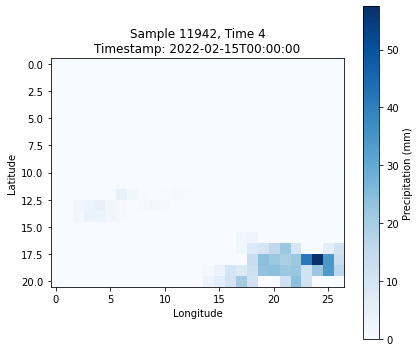

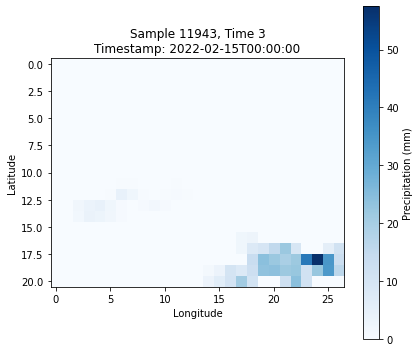

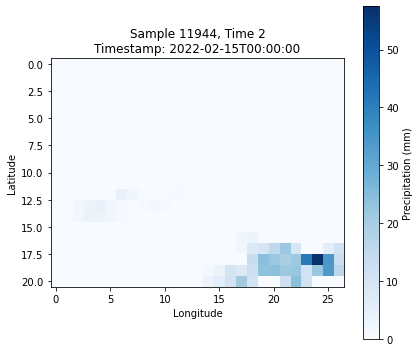

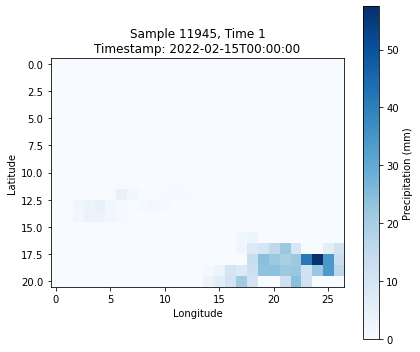

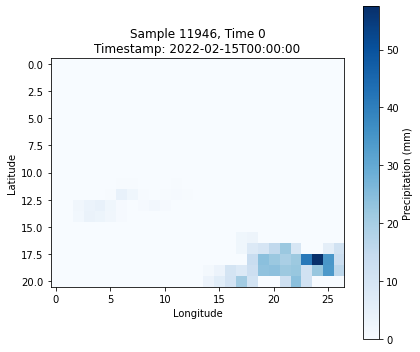

In [15]:
# Plot the target precipitation field (Y) for a user-specified timestamp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# User: set your desired timestamp here (as string, e.g., '2020-12-31T16:00:00')
desired_timestamp = '2022-02-15T00:00:00'  # <-- change this value

if ds is not None and 'y' in ds:
    if 'sample_y_timestamps' in ds.coords:
        timestamps = ds['sample_y_timestamps'].values  # shape: (sample, time)
        # Convert to string for comparison
        timestamps_str = np.array([[str(ts)[:19] for ts in row] for row in timestamps])
        
        # Find all (sample, time) pairs matching the desired timestamp
        matches = np.argwhere(timestamps_str == desired_timestamp)
        if len(matches) == 0:
            print(f"No (sample, time) found with timestamp: {desired_timestamp}")
        else:
            y = ds['y'].values  # (sample, time, lat, lon, channel)
            y_precip = y[..., 0]
            if np.nanmax(y_precip) < 20:
                y_precip = np.expm1(y_precip)
            for idx, (sample_idx, time_idx) in enumerate(matches):
                plt.figure(figsize=(6, 5))
                data = y_precip[sample_idx, time_idx]
                plt.imshow(data, cmap='Blues', aspect='equal')
                plt.colorbar(label='Precipitation (mm)')
                plt.title(f"Sample {sample_idx}, Time {time_idx}\nTimestamp: {desired_timestamp}")
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.tight_layout()
                plt.show()
                if idx >= 9:
                    print("Showing only first 10 matches.")
                    break
    else:
        print("No 'sample_y_timestamps' coordinate found in dataset.")
else:
    print('❌ Dataset not loaded or variable y not found.')

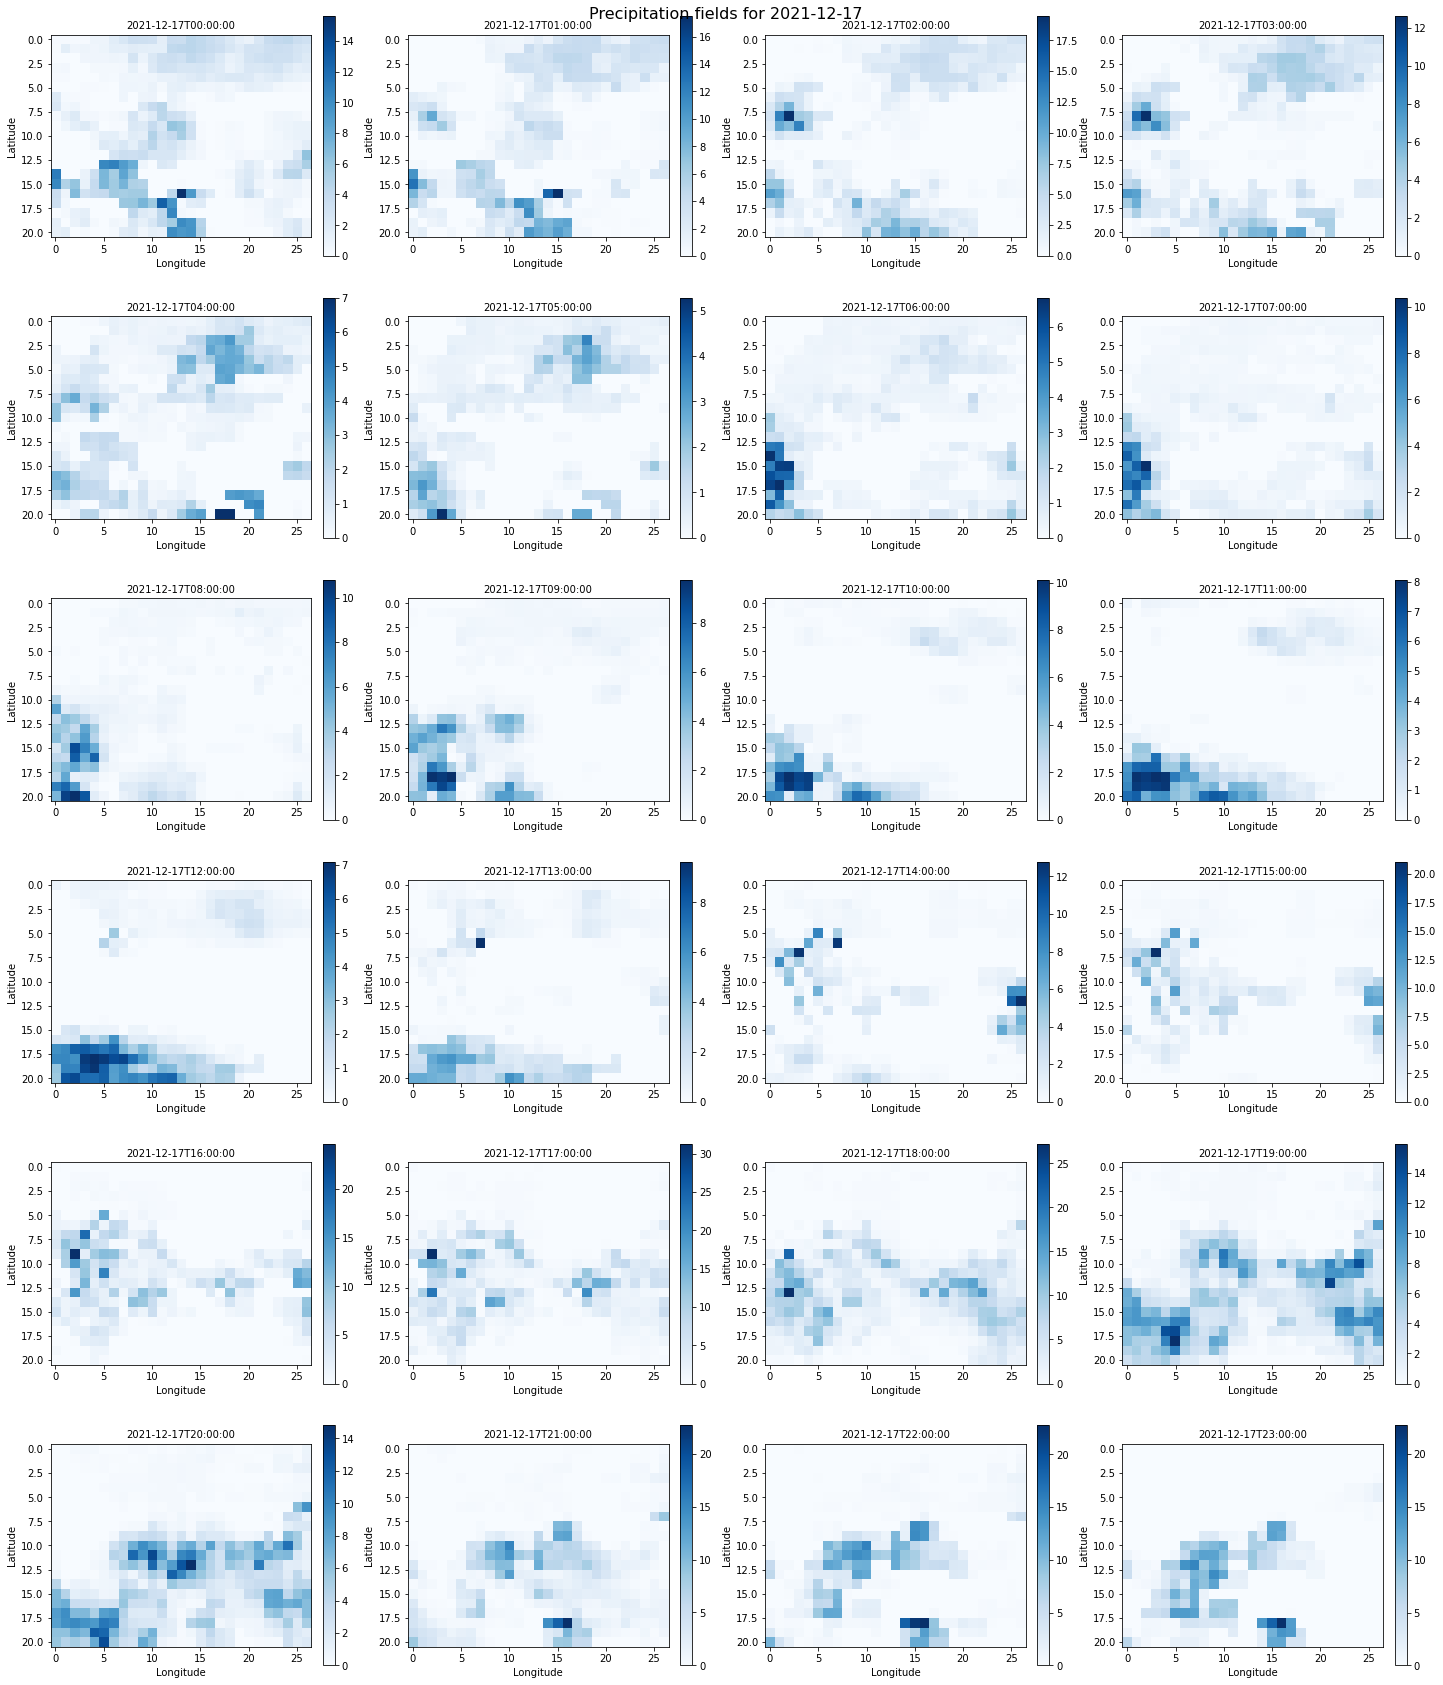

In [16]:
# Plot all unique timesteps for a given day in a grid (one plot per timestep, even if samples overlap)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# User: set your desired day here (as string, e.g., '2022-02-15')
desired_day = '2021-12-17'  # <-- change this value

if ds is not None and 'y' in ds:
    if 'sample_y_timestamps' in ds.coords:
        timestamps = ds['sample_y_timestamps'].values  # shape: (sample, time)
        # Convert to string for comparison
        timestamps_str = np.array([[str(ts)[:19] for ts in row] for row in timestamps])
        # Flatten to (sample, time) -> (N,)
        flat_timestamps = timestamps_str.flatten()
        n_samples, n_times = timestamps_str.shape
        # Find all indices for the desired day
        day_mask = np.char.startswith(flat_timestamps, desired_day)
        # Map flat indices back to (sample, time)
        sample_time_indices = np.array(np.unravel_index(np.where(day_mask)[0], (n_samples, n_times))).T
        # Build a dict: key=timestamp, value=(sample_idx, time_idx)
        ts_to_idx = {}
        for sample_idx, time_idx in sample_time_indices:
            ts = timestamps_str[sample_idx, time_idx]
            if ts not in ts_to_idx:
                ts_to_idx[ts] = (sample_idx, time_idx)
        if not ts_to_idx:
            print(f"No timesteps found for day: {desired_day}")
        else:
            # Sort timestamps
            sorted_ts = sorted(ts_to_idx.keys())
            n_plots = len(sorted_ts)
            ncols = min(4, n_plots)
            nrows = int(np.ceil(n_plots / ncols))
            fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
            if nrows == 1 and ncols == 1:
                axes = np.array([[axes]])
            elif nrows == 1:
                axes = axes.reshape(1, -1)
            elif ncols == 1:
                axes = axes.reshape(-1, 1)
            axes = axes.flatten()
            y = ds['y'].values  # (sample, time, lat, lon, channel)
            y_precip = y[..., 0]
            if np.nanmax(y_precip) < 20:
                y_precip = np.expm1(y_precip)
            for i, ts in enumerate(sorted_ts):
                sample_idx, time_idx = ts_to_idx[ts]
                data = y_precip[sample_idx, time_idx]
                ax = axes[i]
                im = ax.imshow(data, cmap='Blues', aspect='equal')
                ax.set_title(f"{ts}", fontsize=10)
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            # Hide unused axes
            for j in range(i+1, len(axes)):
                axes[j].axis('off')
            plt.suptitle(f'Precipitation fields for {desired_day}', fontsize=16)
            plt.tight_layout()
            plt.show()
    else:
        print("No 'sample_y_timestamps' coordinate found in dataset.")
else:
    print('❌ Dataset not loaded or variable y not found.')

Greatest precipitation value for 2021-12-17: 31.34 mm


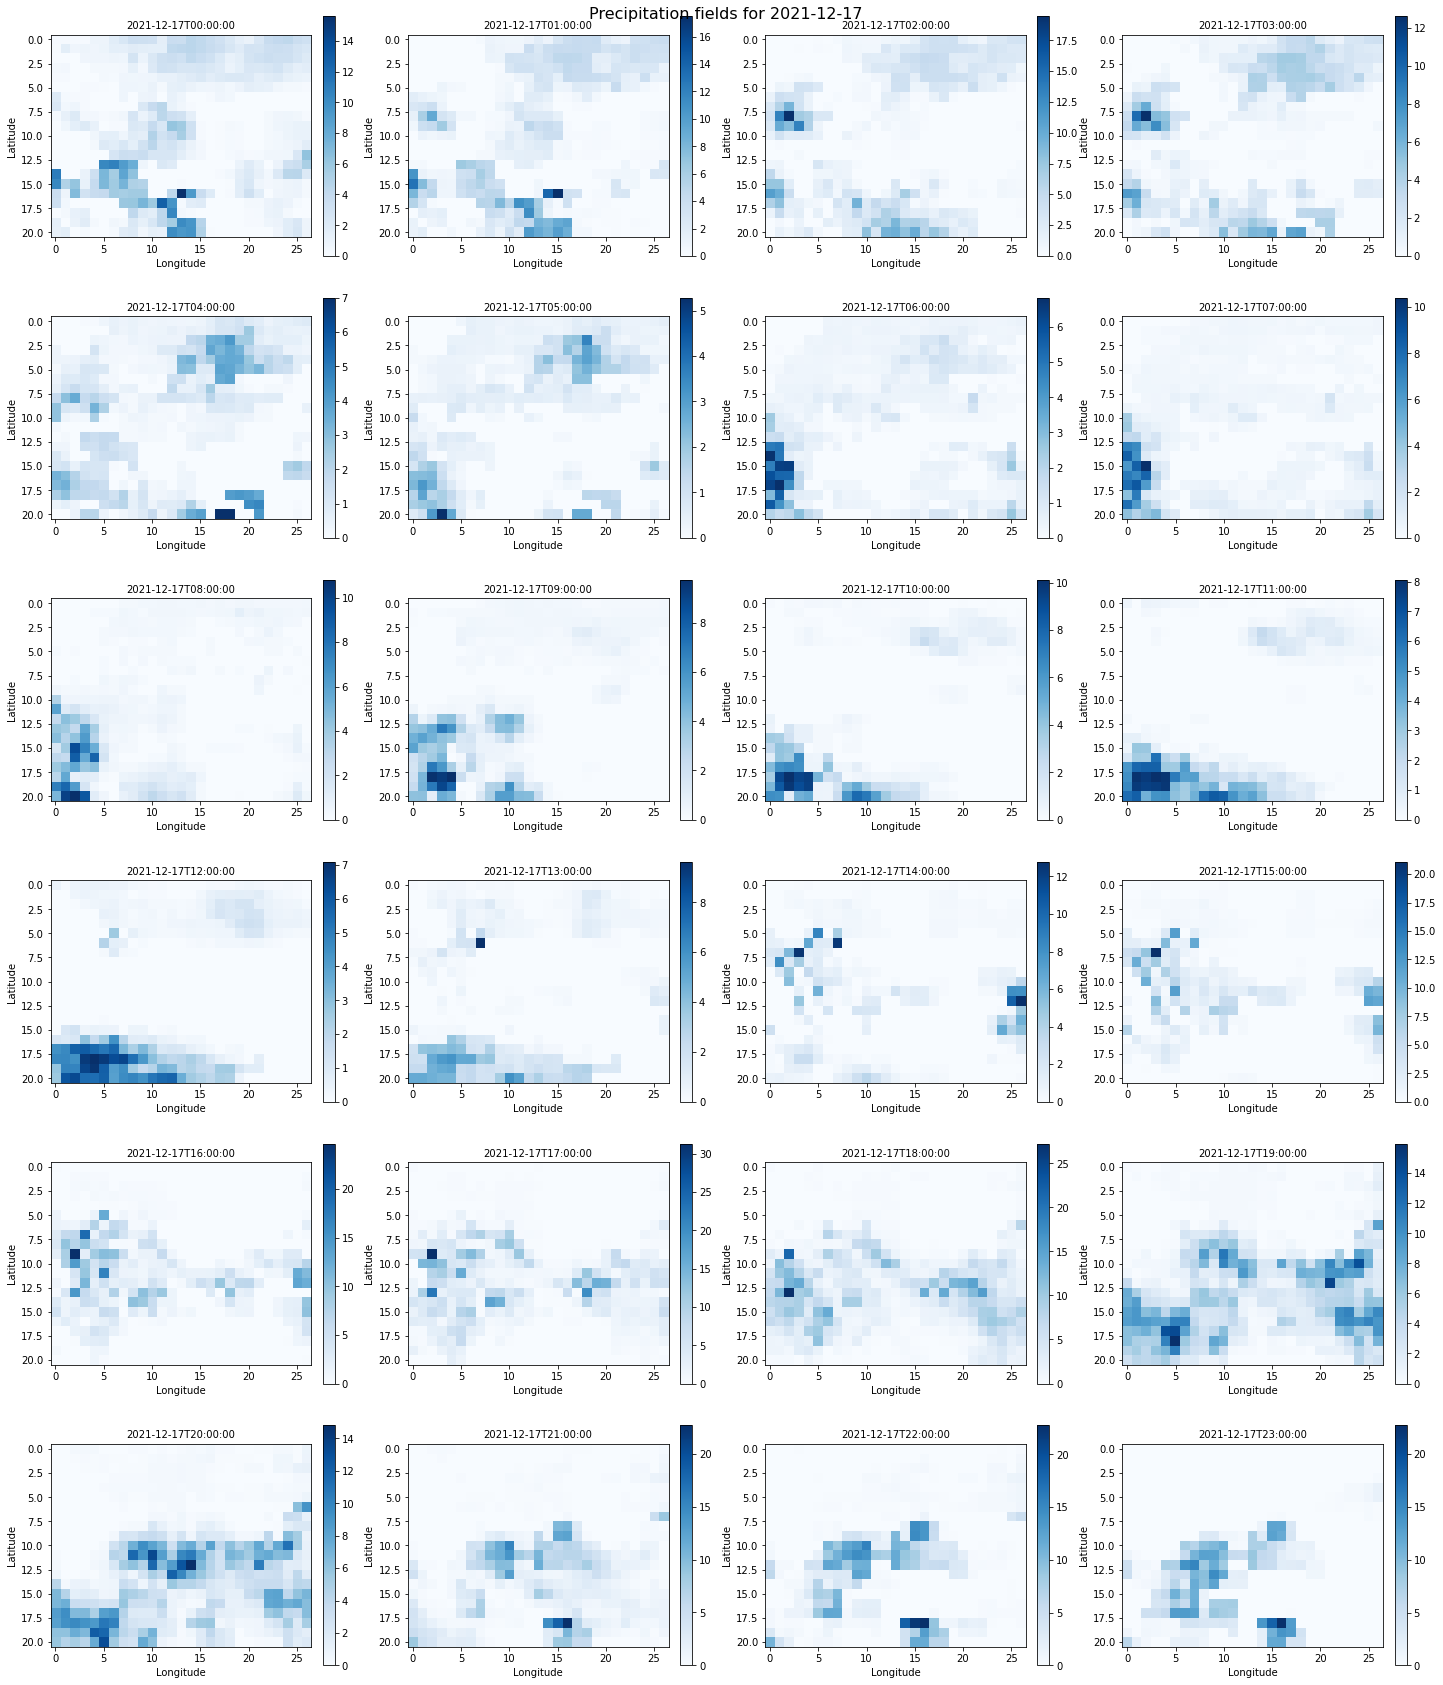

In [17]:
# Plot all unique timesteps for a given day in a grid (one plot per timestep, even if samples overlap) and print the greatest precipitation value for that day
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# User: set your desired day here (as string, e.g., '2022-02-15')
desired_day = '2021-12-17'  # <-- change this value

if ds is not None and 'y' in ds:
    if 'sample_y_timestamps' in ds.coords:
        timestamps = ds['sample_y_timestamps'].values  # shape: (sample, time)
        # Convert to string for comparison
        timestamps_str = np.array([[str(ts)[:19] for ts in row] for row in timestamps])
        # Flatten to (sample, time) -> (N,)
        flat_timestamps = timestamps_str.flatten()
        n_samples, n_times = timestamps_str.shape
        # Find all indices for the desired day
        day_mask = np.char.startswith(flat_timestamps, desired_day)
        # Map flat indices back to (sample, time)
        sample_time_indices = np.array(np.unravel_index(np.where(day_mask)[0], (n_samples, n_times))).T
        # Build a dict: key=timestamp, value=(sample_idx, time_idx)
        ts_to_idx = {}
        for sample_idx, time_idx in sample_time_indices:
            ts = timestamps_str[sample_idx, time_idx]
            if ts not in ts_to_idx:
                ts_to_idx[ts] = (sample_idx, time_idx)
        if not ts_to_idx:
            print(f"No timesteps found for day: {desired_day}")
        else:
            # Find the greatest precipitation value for the day
            y = ds['y'].values  # (sample, time, lat, lon, channel)
            y_precip = y[..., 0]
            if np.nanmax(y_precip) < 20:
                y_precip = np.expm1(y_precip)
            max_precip = -np.inf
            for sample_idx, time_idx in ts_to_idx.values():
                data = y_precip[sample_idx, time_idx]
                max_precip = max(max_precip, np.nanmax(data))
            print(f"Greatest precipitation value for {desired_day}: {max_precip:.2f} mm")
            # Sort timestamps
            sorted_ts = sorted(ts_to_idx.keys())
            n_plots = len(sorted_ts)
            ncols = min(4, n_plots)
            nrows = int(np.ceil(n_plots / ncols))
            fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
            if nrows == 1 and ncols == 1:
                axes = np.array([[axes]])
            elif nrows == 1:
                axes = axes.reshape(1, -1)
            elif ncols == 1:
                axes = axes.reshape(-1, 1)
            axes = axes.flatten()
            for i, ts in enumerate(sorted_ts):
                sample_idx, time_idx = ts_to_idx[ts]
                data = y_precip[sample_idx, time_idx]
                ax = axes[i]
                im = ax.imshow(data, cmap='Blues', aspect='equal')
                ax.set_title(f"{ts}", fontsize=10)
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            # Hide unused axes
            for j in range(i+1, len(axes)):
                axes[j].axis('off')
            plt.suptitle(f'Precipitation fields for {desired_day}', fontsize=16)
            plt.tight_layout()
            plt.show()
    else:
        print("No 'sample_y_timestamps' coordinate found in dataset.")
else:
    print('❌ Dataset not loaded or variable y not found.')

In [18]:
freqs = np.array([61259762, 1370416, 35176, 2321])
weights = 1.0 / np.sqrt(freqs + 1e-8)
weights = weights / weights.sum()
print([f"{w:.8f}" for w in weights])

['0.00471968', '0.03155541', '0.19695947', '0.76676543']
